In [1]:
import os
import math
import numpy as np
import preprocessing as prep
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['LD_LIBRARY_PATH'] = '$LD_LIBRARY_PATH:/opt/rocm-5.3.0/lib'

2023-04-17 11:35:48.517039: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file = '1.145414064.json'
prep.get_info(file)

Event ID: 28797319
Market Time: 2018-07-11T10:00:00.000Z
Runner IDs and names: 
2249834, Juan Martin Del Potro
2251410, Rafael Nadal


In [3]:
runner_id_1 = 2249834
runner_id_2 = 2251410
df_odds = prep.odds_avg(file, runner_id_1, runner_id_2)
implied_odds = df_odds['avg'].to_numpy()

                         runner 1  1 - runner 2       avg
2018-07-11 14:52:07.000   0.30303      0.295775  0.299402
2018-07-11 14:52:07.250   0.30303      0.295775  0.299402
2018-07-11 14:52:07.500   0.30303      0.295775  0.299402
2018-07-11 14:52:07.750   0.30303      0.295775  0.299402
2018-07-11 14:52:08.000   0.30303      0.295775  0.299402
...                           ...           ...       ...
2018-07-11 19:50:14.500   0.05000      0.047619  0.048810
2018-07-11 19:50:14.750   0.05000      0.047619  0.048810
2018-07-11 19:50:15.000   0.05000      0.047619  0.048810
2018-07-11 19:50:15.250   0.05000      0.047619  0.048810
2018-07-11 19:50:15.500   0.05000      0.047619  0.048810

[71555 rows x 3 columns]


In [4]:
train_len = math.ceil(len(implied_odds) * 0.8)

values = implied_odds.reshape(-1, 1)
train_data = values[0: train_len, :]
x_train = []
y_train = []

for i in range(128, len(train_data)):
    x_train.append(train_data[i - 128:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = values[train_len-128: , : ]
x_test = []
y_test = values[train_len:]

for i in range(128, len(test_data)):
    x_test.append(test_data[i-128:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [5]:
model = keras.Sequential()
model.add(layers.LSTM(64, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(64, return_sequences=False))
model.add(layers.Dense(16))
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 128, epochs=2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128, 64)           16896     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 50,977
Trainable params: 50,977
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2
447/447 [==============================] - 8s 13ms/step - loss: 7.4976e-04
Epoch 2/2
447/447 [==============================] - 6s 13ms/step - loss: 3.0963e-06


In [6]:
predictions = model.predict(x_test)
mse = np.mean(predictions - y_test)**2
rmse = np.sqrt(mse)
print("The mse for this prediction is: " + str(mse))
print("The rmse for this prediction is: " + str(rmse))


448/448 [==============================] - 2s 4ms/step
The mse for this prediction is: 8.450649527240132e-07
The rmse for this prediction is: 0.0009192741444879287


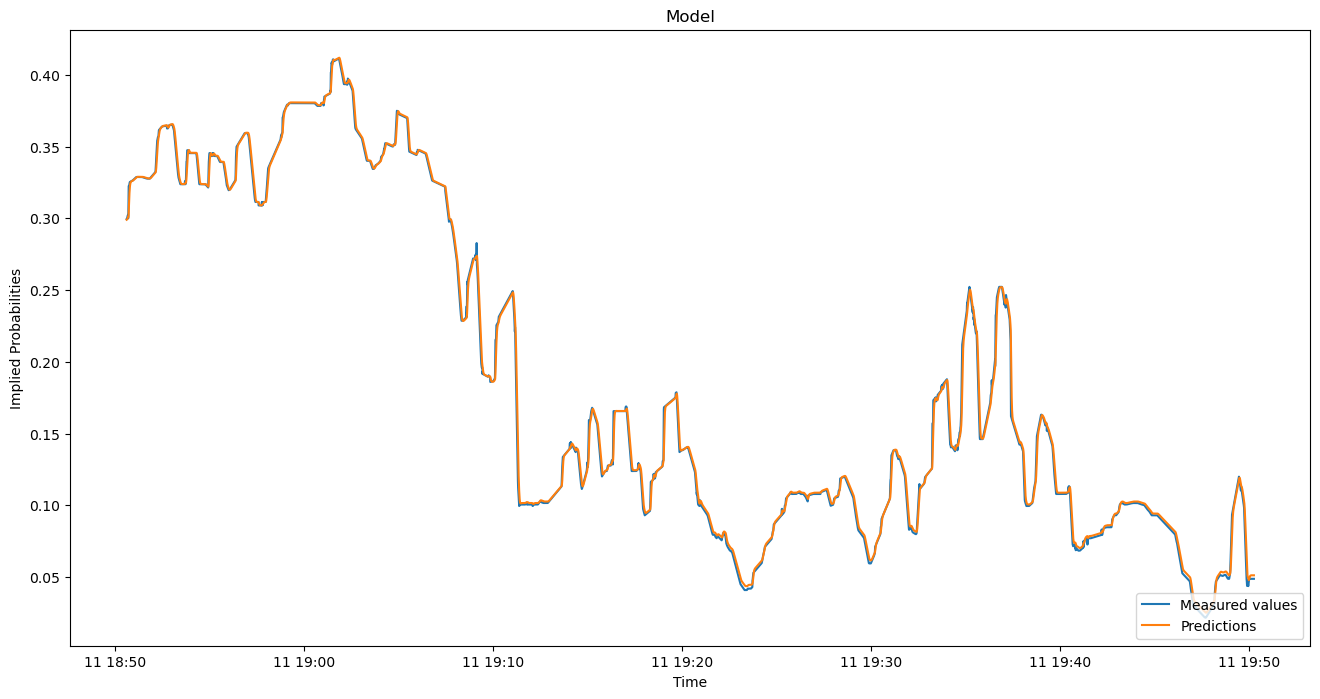

In [7]:
validation = df_odds[train_len:]
df_pred = pd.DataFrame(predictions, columns = ['pred_odds'])
df_pred.index = validation.index
validation = pd.concat([validation,df_pred],axis=1)
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Time')
plt.ylabel('Implied Probabilities')
plt.plot(validation[['avg','pred_odds']])
plt.legend(['Measured values', 'Predictions'], loc='lower right')
plt.show()